In [1]:
import glob

import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynndescent
import scanpy as sc
import seaborn as sns
from ALLCools.clustering import *
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from scipy.stats import zscore
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, normalize
from wmb import aibs, brain, broad, mm10

mpl.style.use("default")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"

In [2]:
region_to_subregion = {
    "CTX": ["MOp", "SSp", "ACA", "AI", "RSP", "AUD", "PTLp", "VIS"],
    "HIP": ["CAa", "CAp", "DGa", "DGp"],
    "RHP": ["ENT"],
    "OLF": ["MOB", "AON"],
    "PIR": ["PIRa", "PIRp"],
    # "STR": ["STR"],
    "PAL": ["PAL"],
    "AMY": ["AMY"],
    "TH": ["THm", "THl", "THp"],
    "HY": ["HY"],
    "MB": ["SC", "MRN", "VTA", "PAG", "IC"],
    "HB": ["P", "MY"],
}
rs1_subregion_dict = {
    "MOp": ["MOp-2", "MOp-3"],
    "SSp": ["SSp-3", "SSp-4"],
    "ACA": ["PFC-2", "ACA-1", "ACA-2"],
    "AI": ["AI"],
    "RSP": ["RSP-3", "RSP-4"],
    "AUD": ["AUD-1", "AUD-2"],
    "PTLp": ["PTLp"],
    "VIS": ["VIS-2", "VIS-3"],
    "ENT": ["RHP-1", "RHP-2", "RHP-3", "RHP-5"],
    "CAa": ["CA-i", "CA-ii"],
    "CAp": ["CA-iii", "CA-iv"],
    "DGa": ["DG-1", "DG-2"],
    "DGp": ["DG-3", "DG-4"],
    "PIRa": ["PIR-1", "PIR-2", "PIR-3", "PIR-4"],
    "PIRp": ["PIR-5", "PIR-6", "PIR-7", "PIR-8"],
    "MOB": ["MOB"],
    "AON": ["AON"],
    "PAL": ["PAL-1", "PAL-2", "PAL-3", "GP"],
    "STR": ["CP-1", "CP-2", "CP-3"],
    "AMY": ["AMY-1", "AMY-2", "AMY-3"],
    "THl": ["TH-1", "TH-3"],
    "THm": ["TH-2", "TH-4"],
    "THp": ["TH-5", "TH-6", "TH-7"],
    "HY": ["HY-1", "HY-2", "HY-3", "HY-4"],
    "SC": ["SC-1", "SC-2", "SC-3"],
    "MRN": ["PAG-3", "PAG-4", "MRN"],
    "VTA": ["VTA-1", "VTA-2"],
    "PAG": ["PAG-1", "PAG-2"],
    "IC": ["IC-1"],
    "P": ["PRN-1", "PRN-2", "PRN-3", "PRN-4", "PCG"],
    "MY": ["MY-1", "MY-2", "MY-3", "MY-4"],
}

rs2_subregion_dict = {
    "MOp": ["3C", "4B"],
    "SSp": ["6B", "7B"],
    "ACA": ["3A", "4A", "5A"],
    "AI": ["3D"],
    "RSP": ["9A", "10A"],
    "AUD": ["9D", "10C"],
    "PTLp": ["9B"],
    "VIS": ["11B", "12B"],
    "ENT": ["10D11D12D13B"],
    "CAa": ["8E9H"],
    "CAp": ["10E11E"],
    "DGa": ["8J9J"],
    "DGp": ["10F11F"],
    "PIRa": ["2D3E4F5G"],
    "PIRp": ["6D7D8D9E"],
    "MOB": ["1C"],
    "AON": ["2E"],
    "PAL": ["4H5H6F7F", "6F7F"],
    "STR": ["4D5E6E"],
    "AMY": ["7H8H9G"],
    "THl": ["7E8F"],
    "THm": ["7G8G"],
    "THp": ["9K10G"],
    "HY": ["6H7J8K9L"],
    "SC": ["11G12F13C"],
    "MRN": ["10H11H12H"],
    "VTA": ["10J11J"],
    "PAG": ["12G13D"],
    "IC": ["14A"],
    "P": ["12J13E13F14C14D"],
    "MY": ["15C16C17B18B"],
}

In [3]:
tarall = [
    "PFC",
    "MOp",
    "SSp",
    "ACA",
    "AI",
    "AUDp",
    "RSP",
    "PTLp",
    "VISp",
    "MOB",
    "ENT",
    "HPF",
    "PIR",
    "AMY",
    "STR",
    "PAL",
    "TH",
    "HY",
    "SC",
    "VTA",
    "P",
    "MY",
    "CBN",
    "CBX",
]

In [4]:
meta_rs2 = pd.read_csv(
    "/cemba/CEMBA_RS2/cell_48032_RS2_meta_nooutlier.csv.gz", index_col=0, header=0
)
meta_rs2 = meta_rs2.loc[meta_rs2["PassTargetFilter"]]

In [5]:
hip_list = [0, 1, 2, 3, 4, 5, 6, 8, 23, 25, 27, 34]
hip_map = {xx: 0 for xx in hip_list}
olf_list = [0, 1, 2, 3, 4, 6, 8, 9, 13, 14, 15, 16, 17, 46]
olf_map = {xx: 0 for xx in olf_list}

In [6]:
marker = [
    "Slc17a6",
    "Slc17a7",
    "Slc17a8",
    "Slc32a1",
    "Slc6a2",
    "Slc6a3",
    "Slc6a4",
    "Slc6a5",
    "Slc18a3",
    "Hdc",
]
nt = ["vGlut2", "vGlut1", "vGlut3", "vGAT", "NA", "Dopa", "Sero", "Gly", "ACh", "Hist"]

In [7]:
region_to_subregion.keys()

dict_keys(['CTX', 'HIP', 'RHP', 'OLF', 'PIR', 'PAL', 'AMY', 'TH', 'HY', 'MB', 'HB'])

In [18]:
size_params = {
    'CTX': [16, 5.5, 8.5],
    'RHP': [5, 4, 1],
    'PIR': [5.5, 4, 1.6],
    'HIP': [4.5, 3, 1.6],
    'OLF': [5, 3, 1],
    'PAL': [5, 3, 0.6],
    'AMY': [5, 3.5, 1.1],
    'TH': [7, 5.5, 3],
    'HY': [5.5, 3.5, 1.2],
    'MB': [9, 6, 3],
    'HB': [5.5, 3.5, 1.3],
}

In [9]:
from wmb import aibs, mm10

In [10]:
expr = pd.concat([aibs.get_tenx_gene_data(xx) for xx in marker], axis=1)
expr.columns = nt

CTX (90, 34)
HIP (13, 13)
RHP (9, 20)
OLF (8, 14)
PIR (13, 18)
PAL (5, 13)
AMY (9, 16)
TH (25, 35)
HY (10, 17)
MB (30, 39)
HB (11, 20)


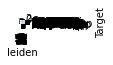

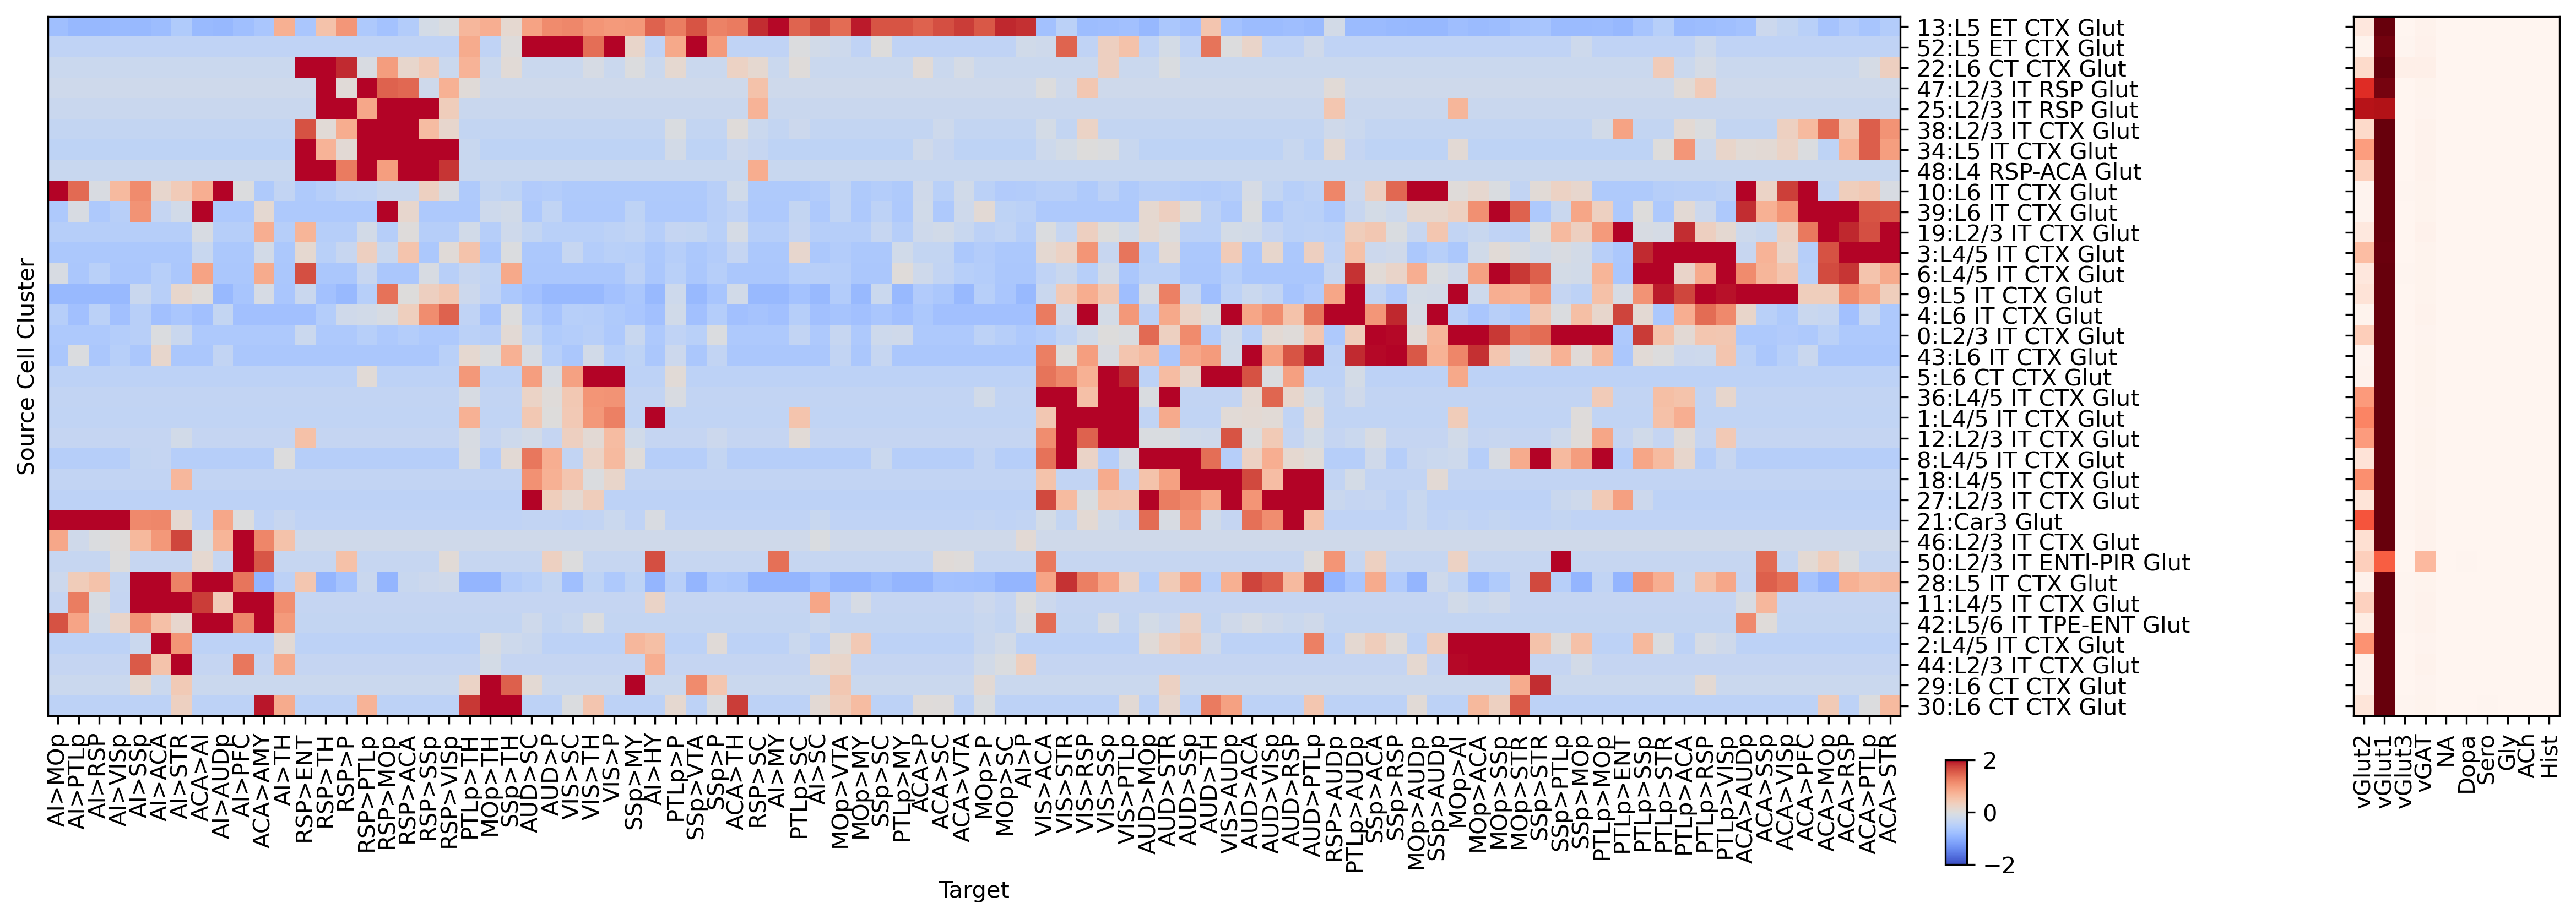

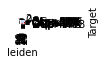

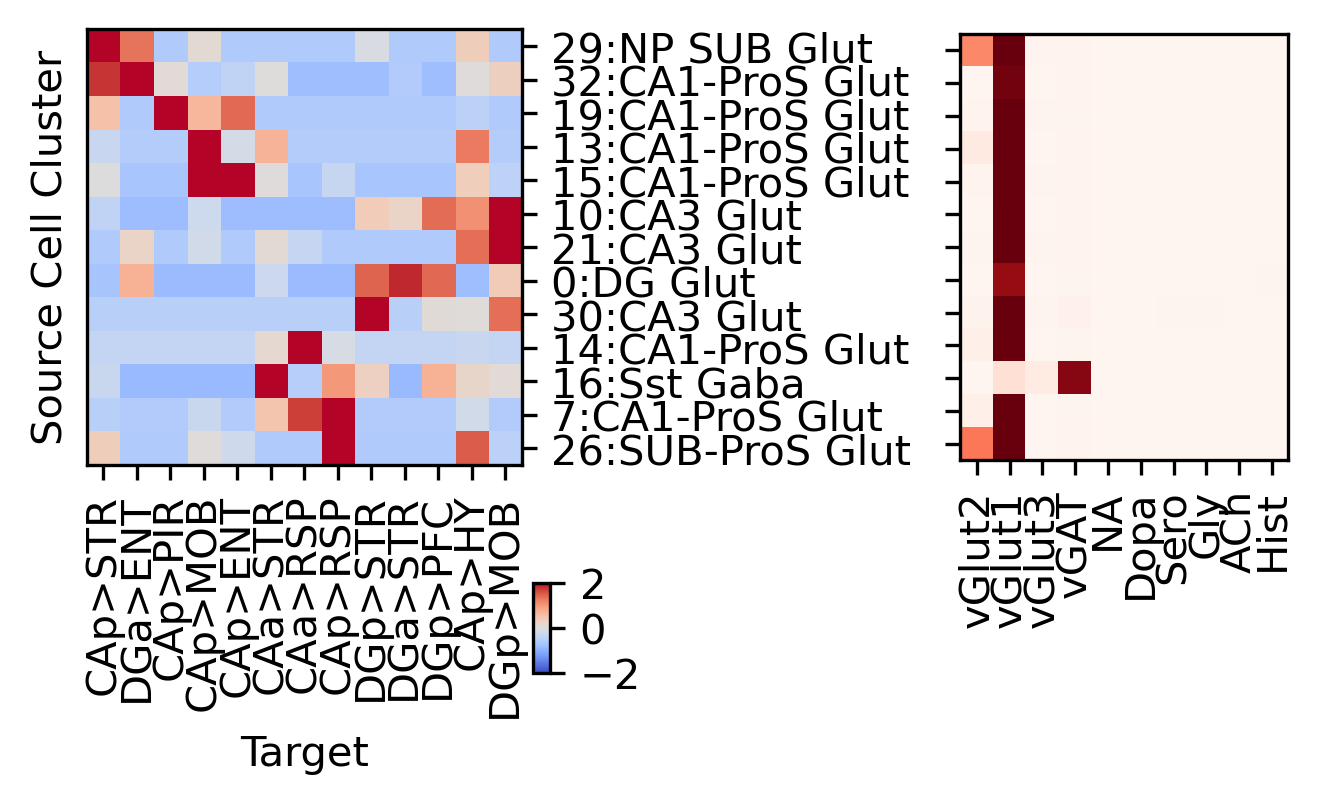

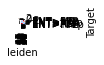

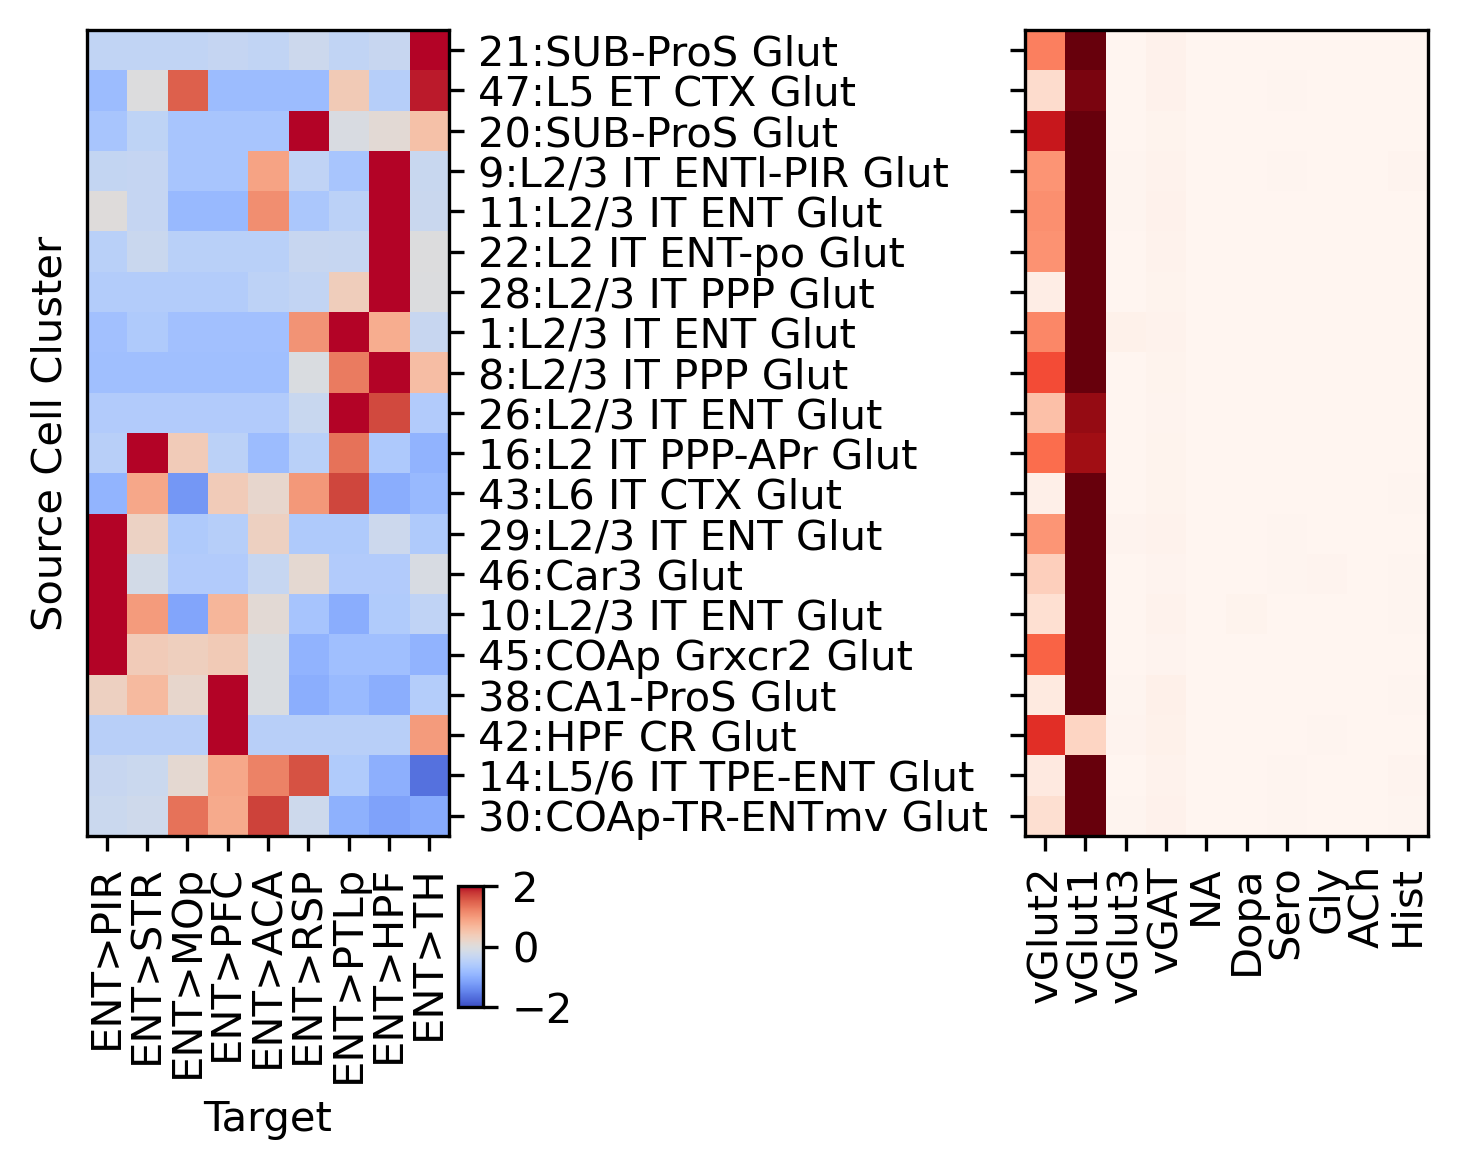

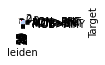

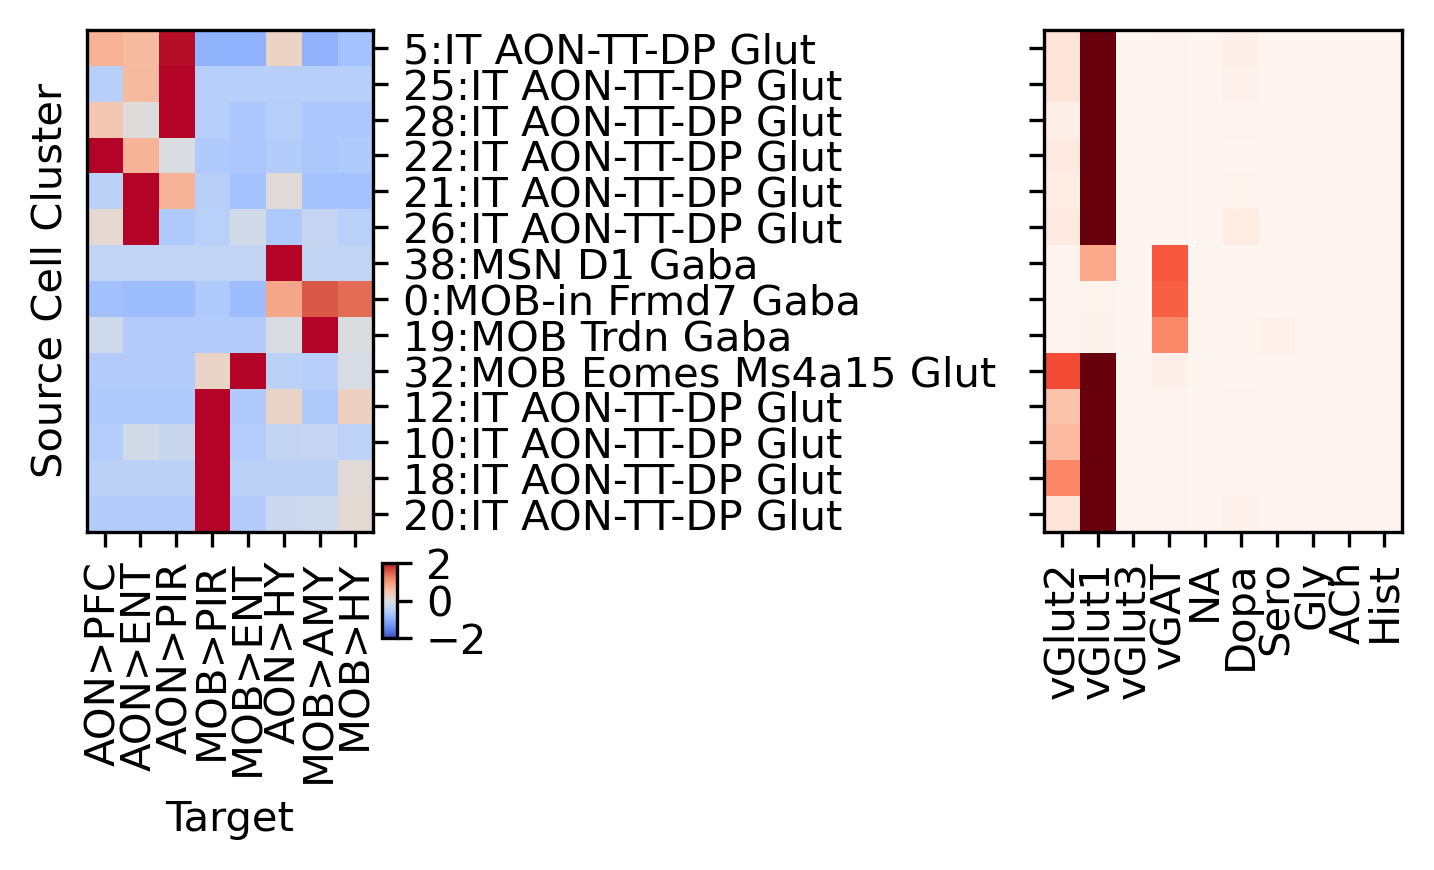

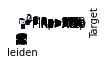

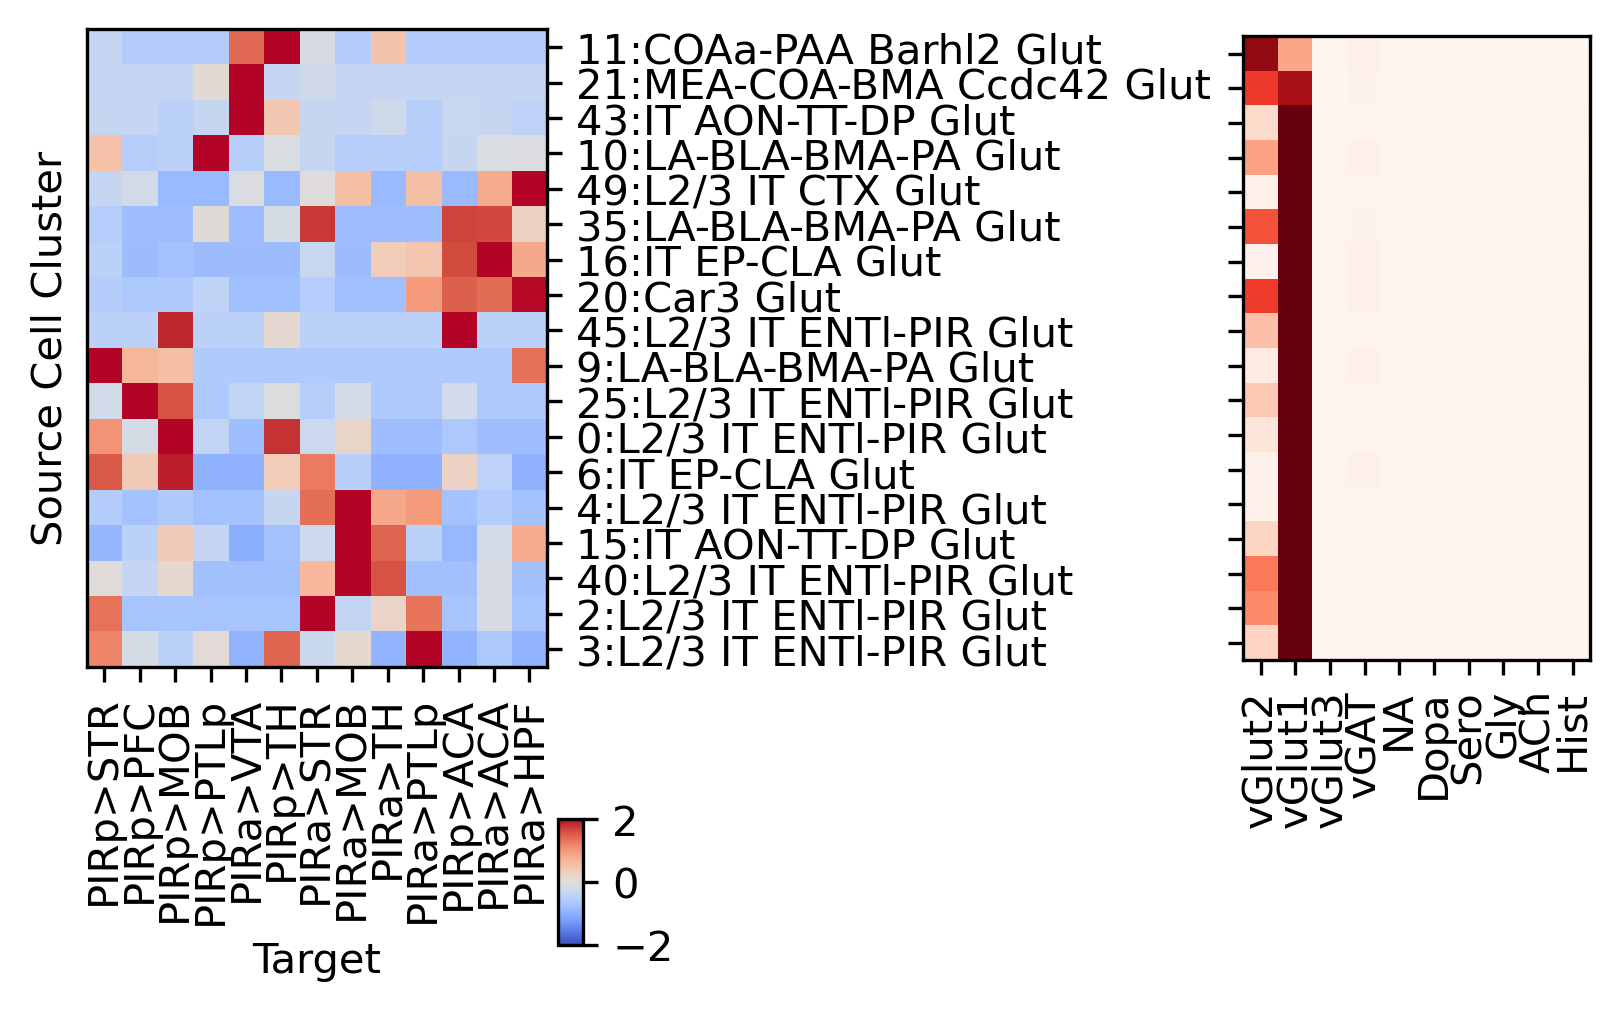

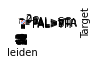

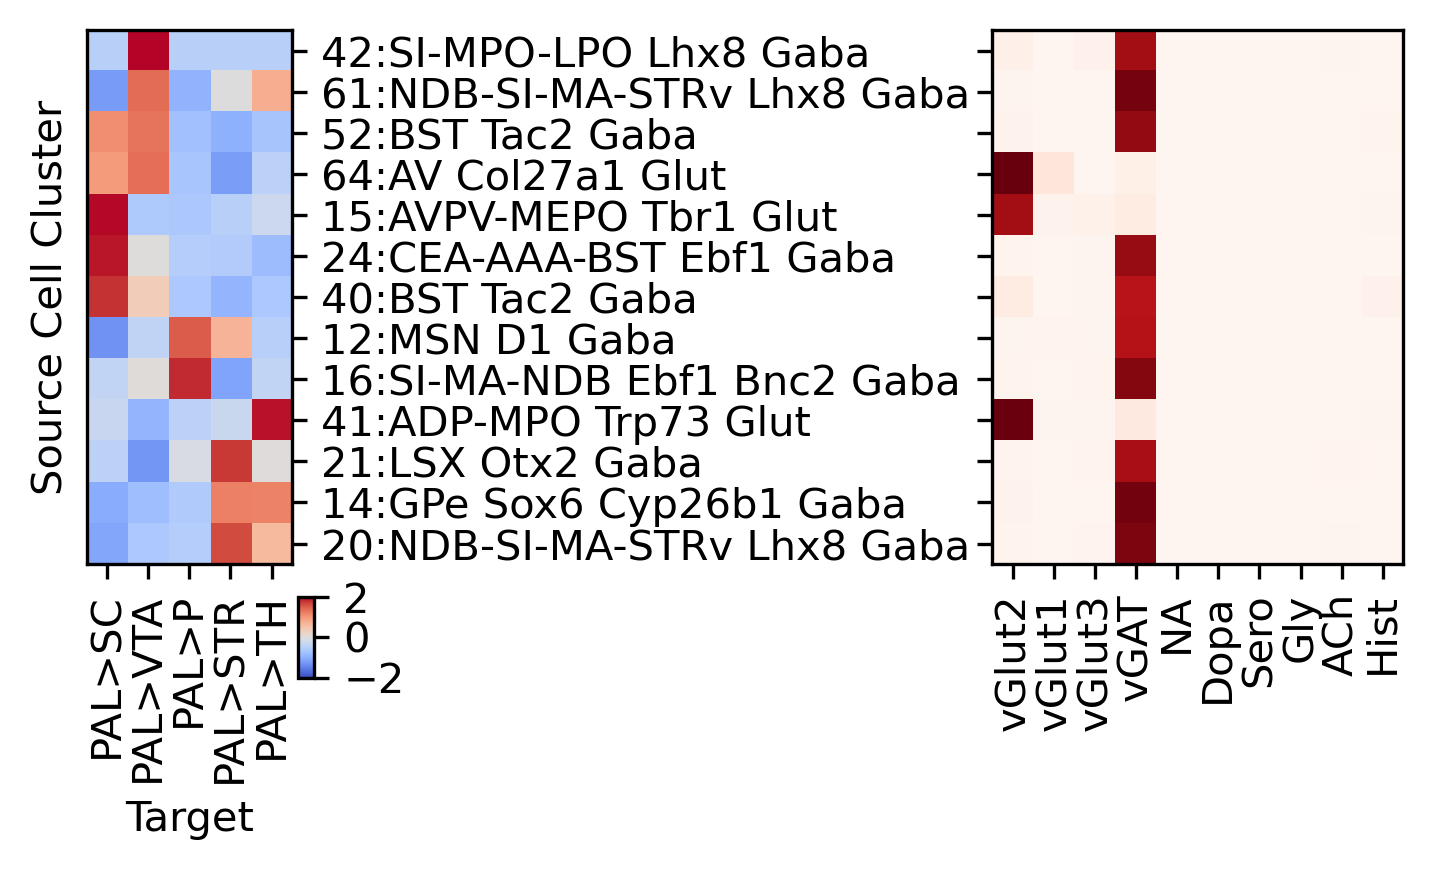

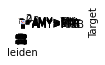

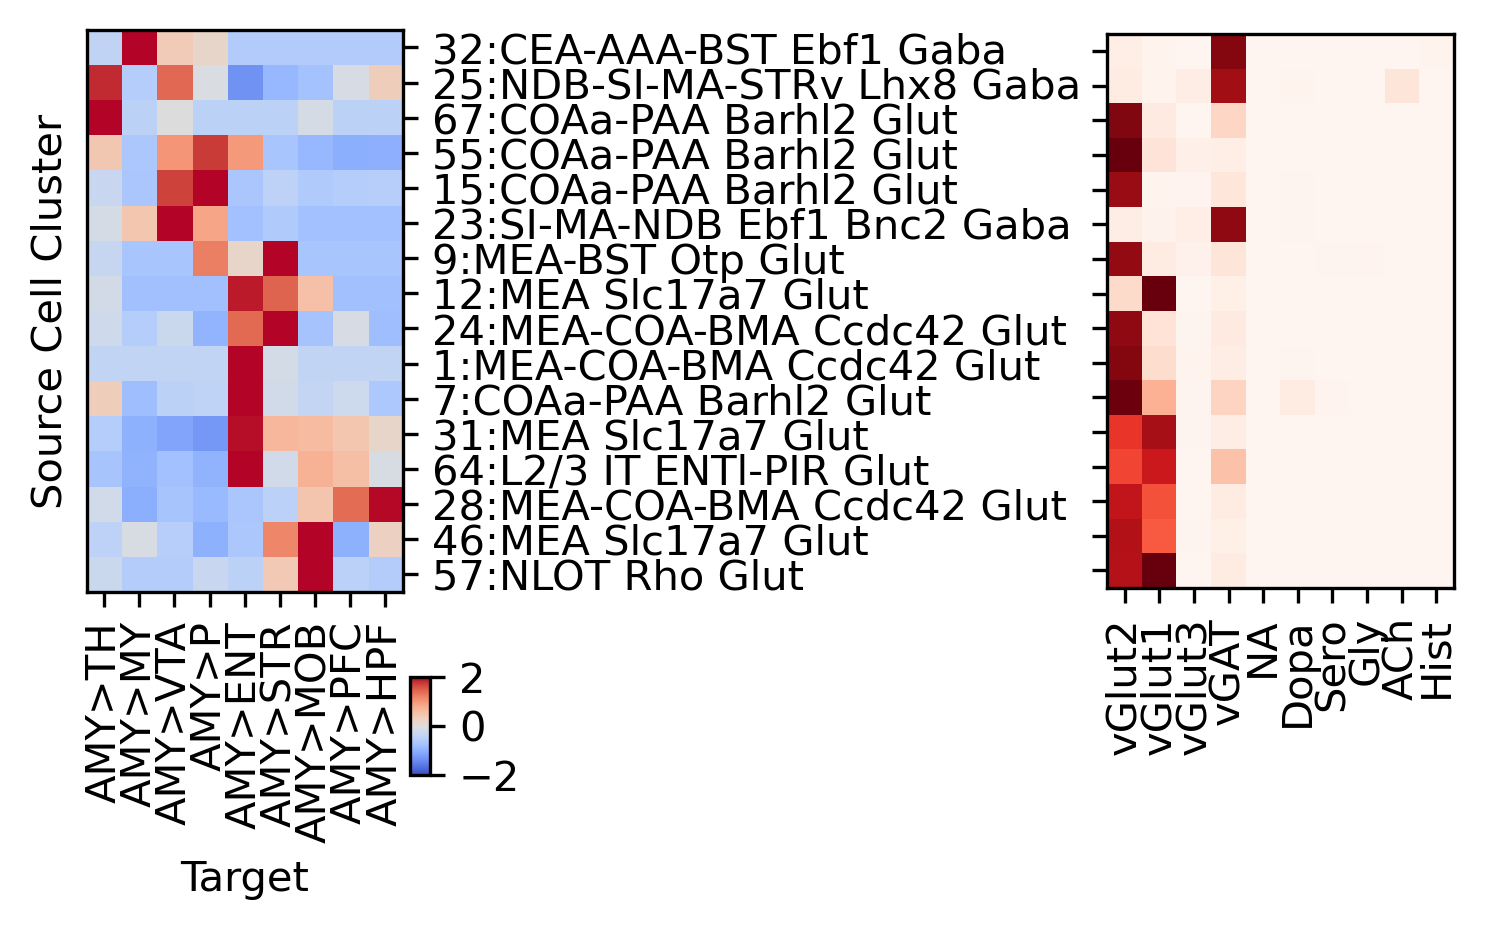

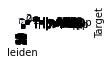

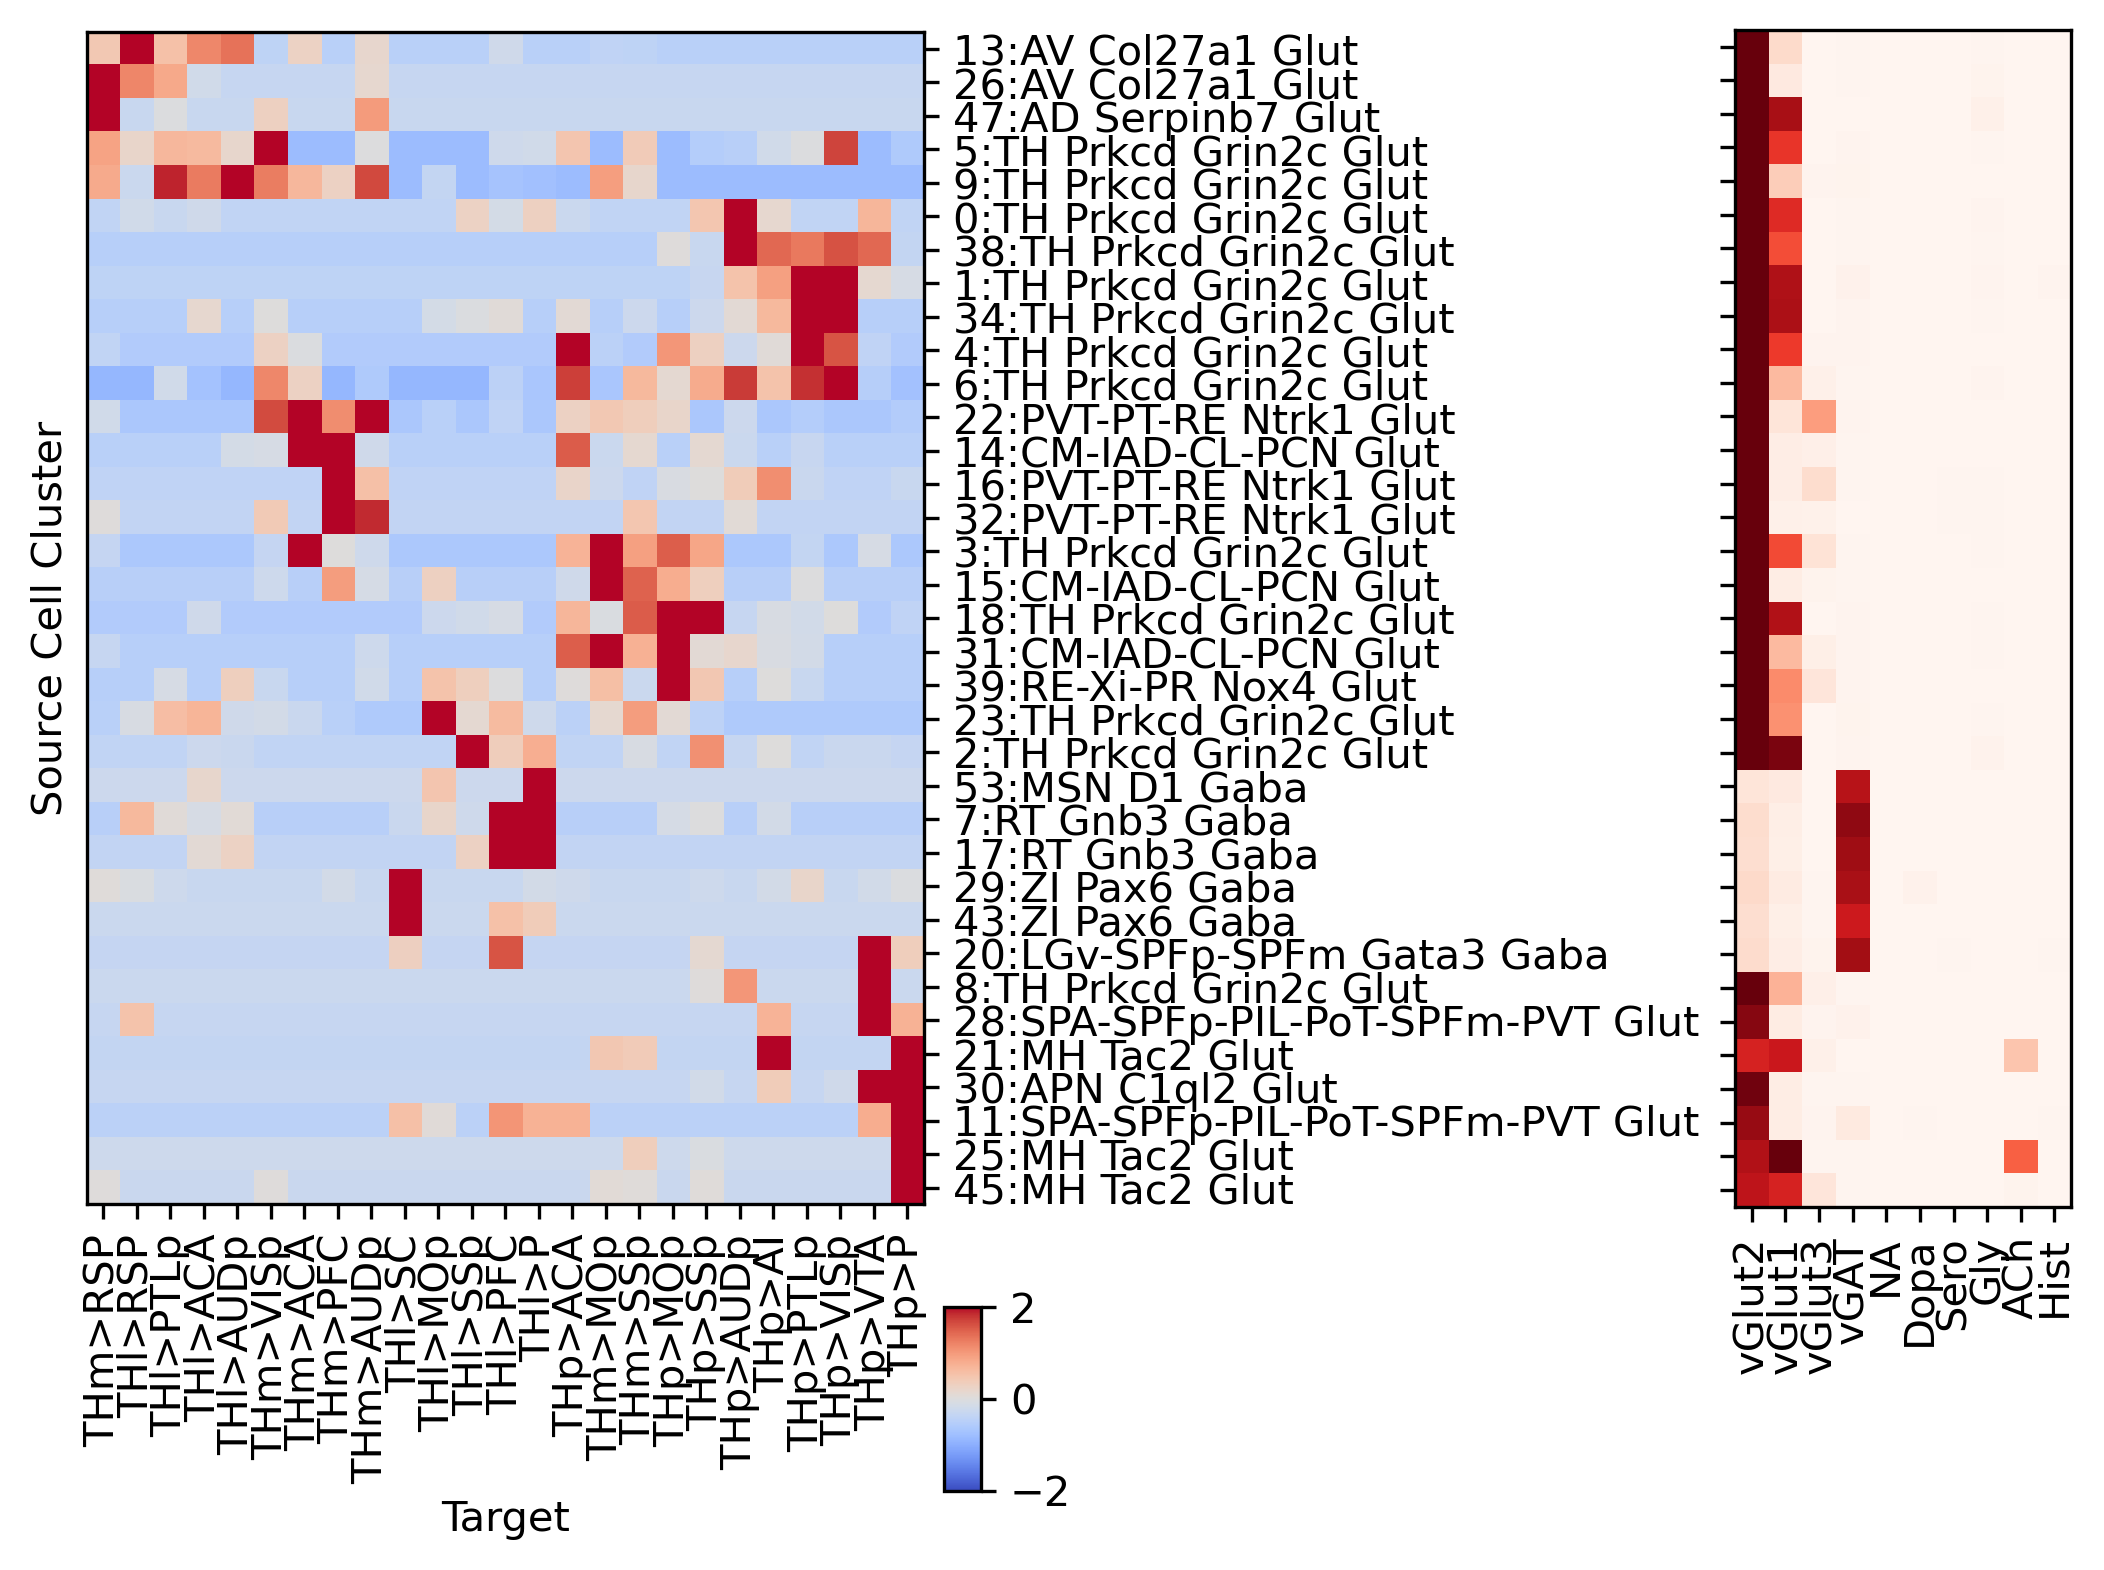

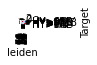

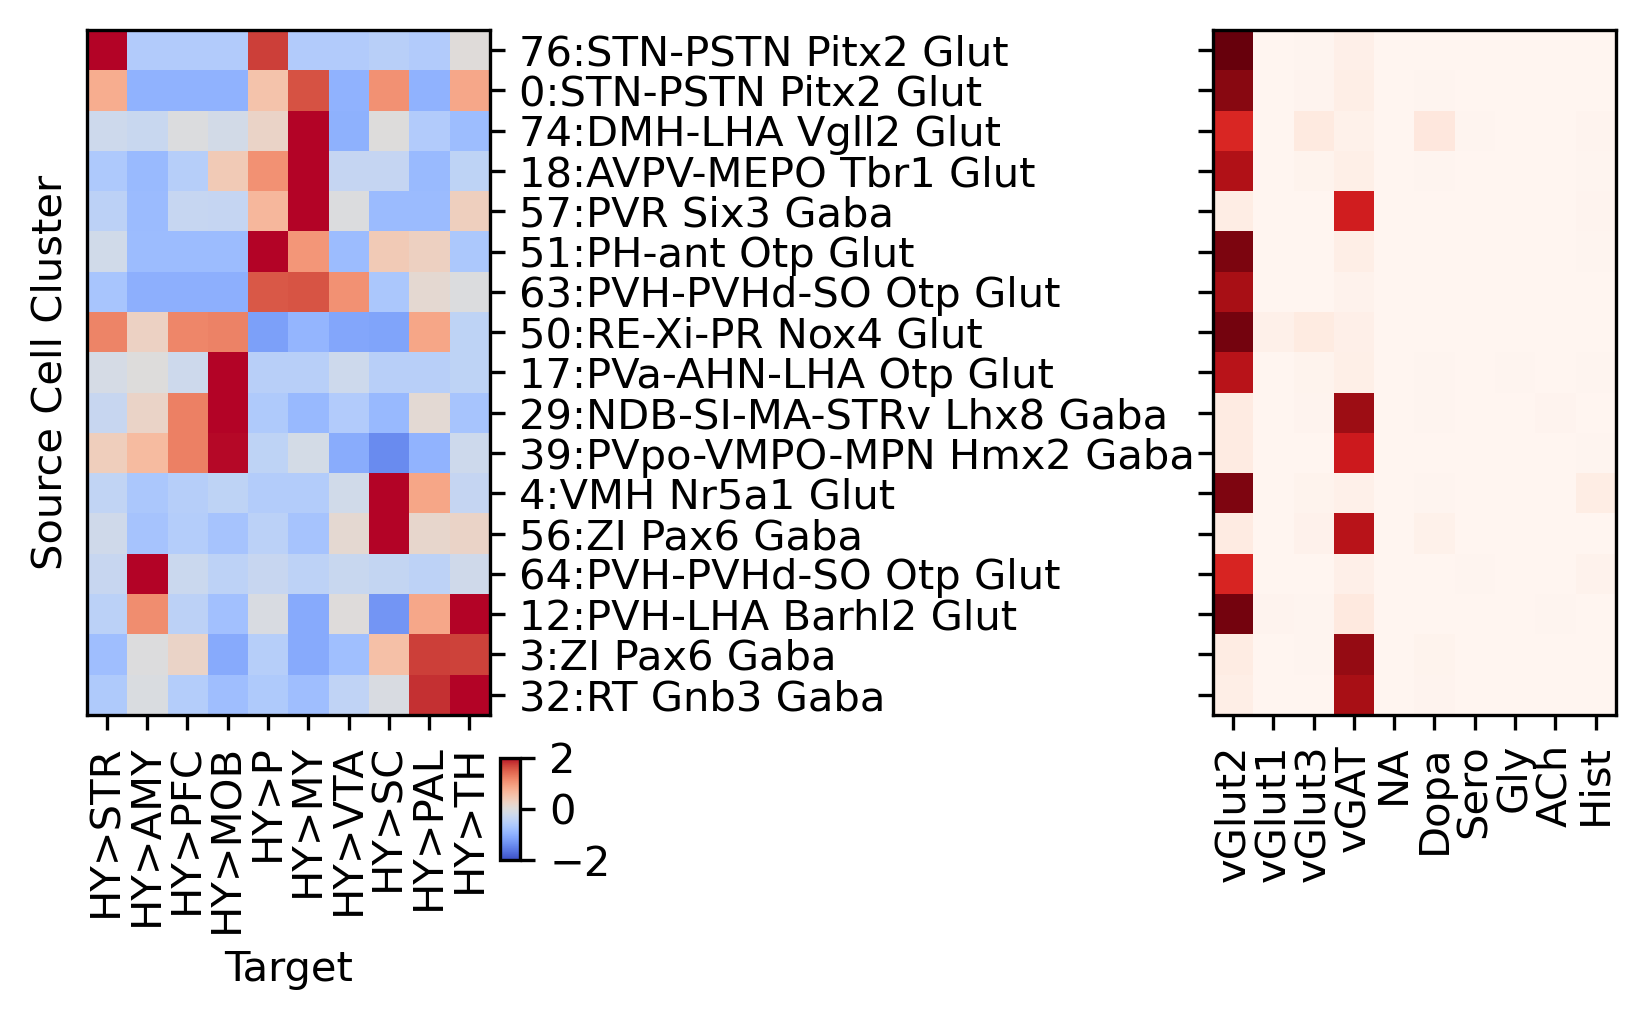

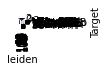

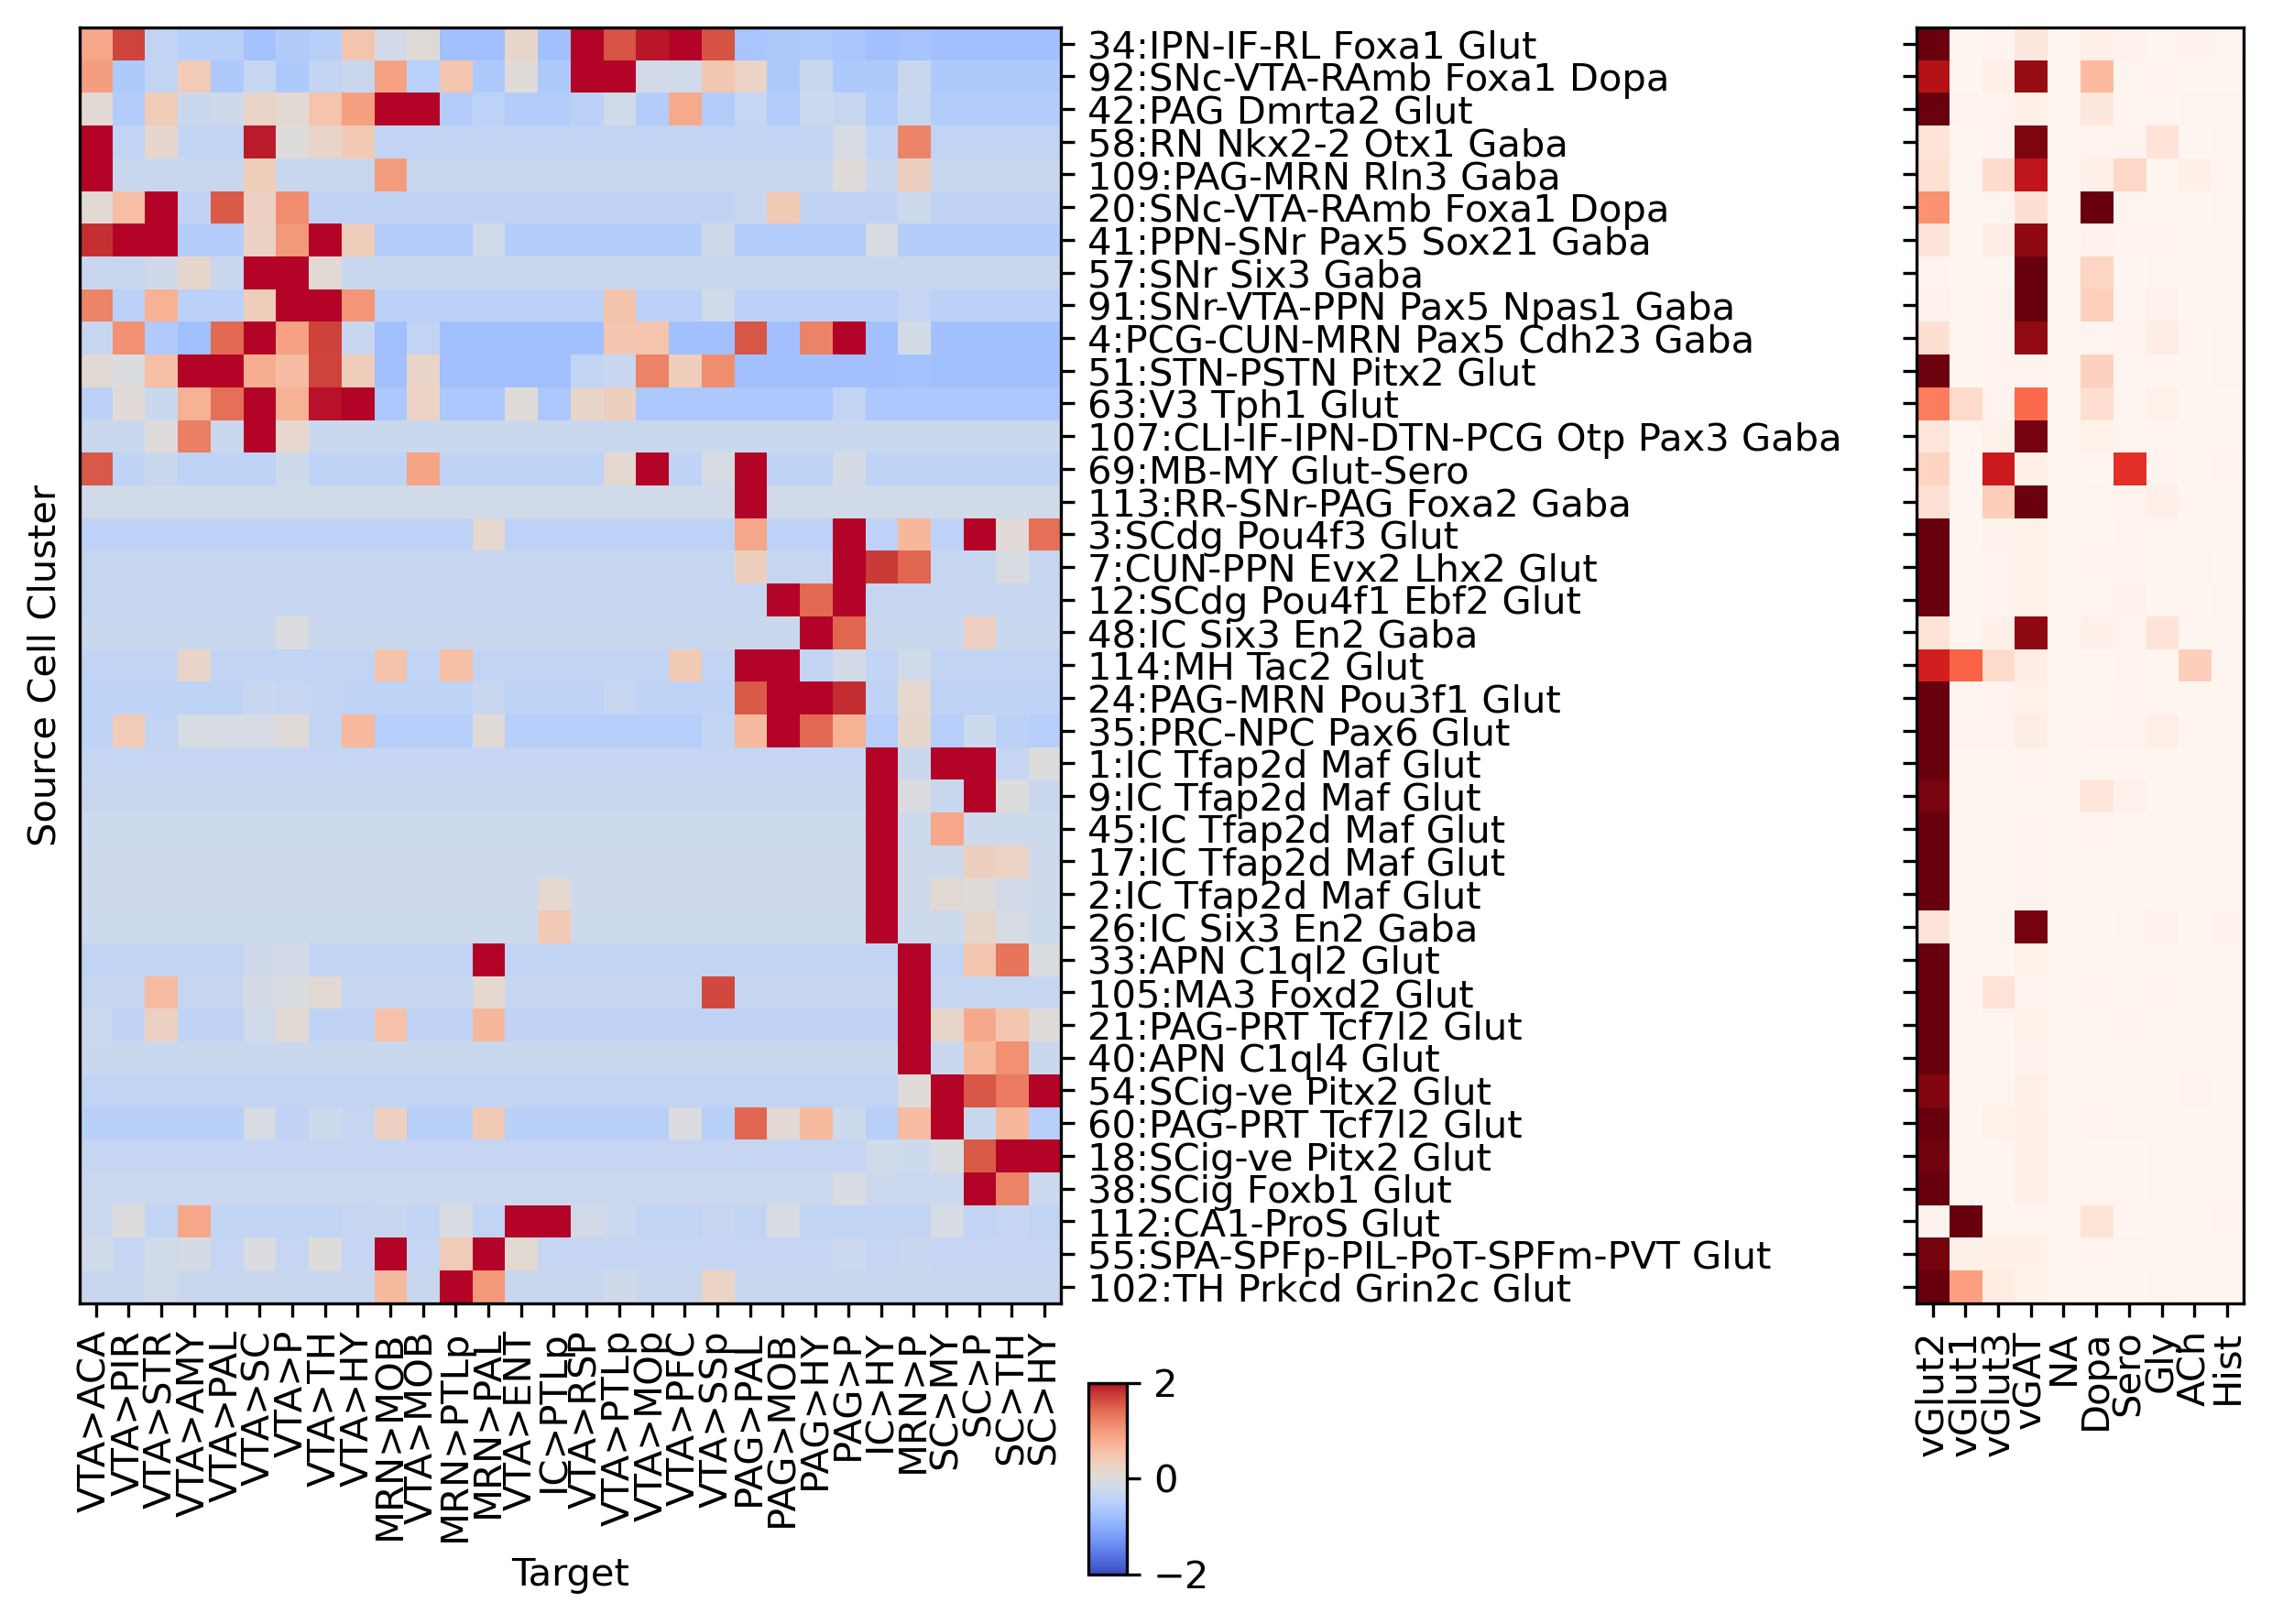

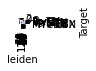

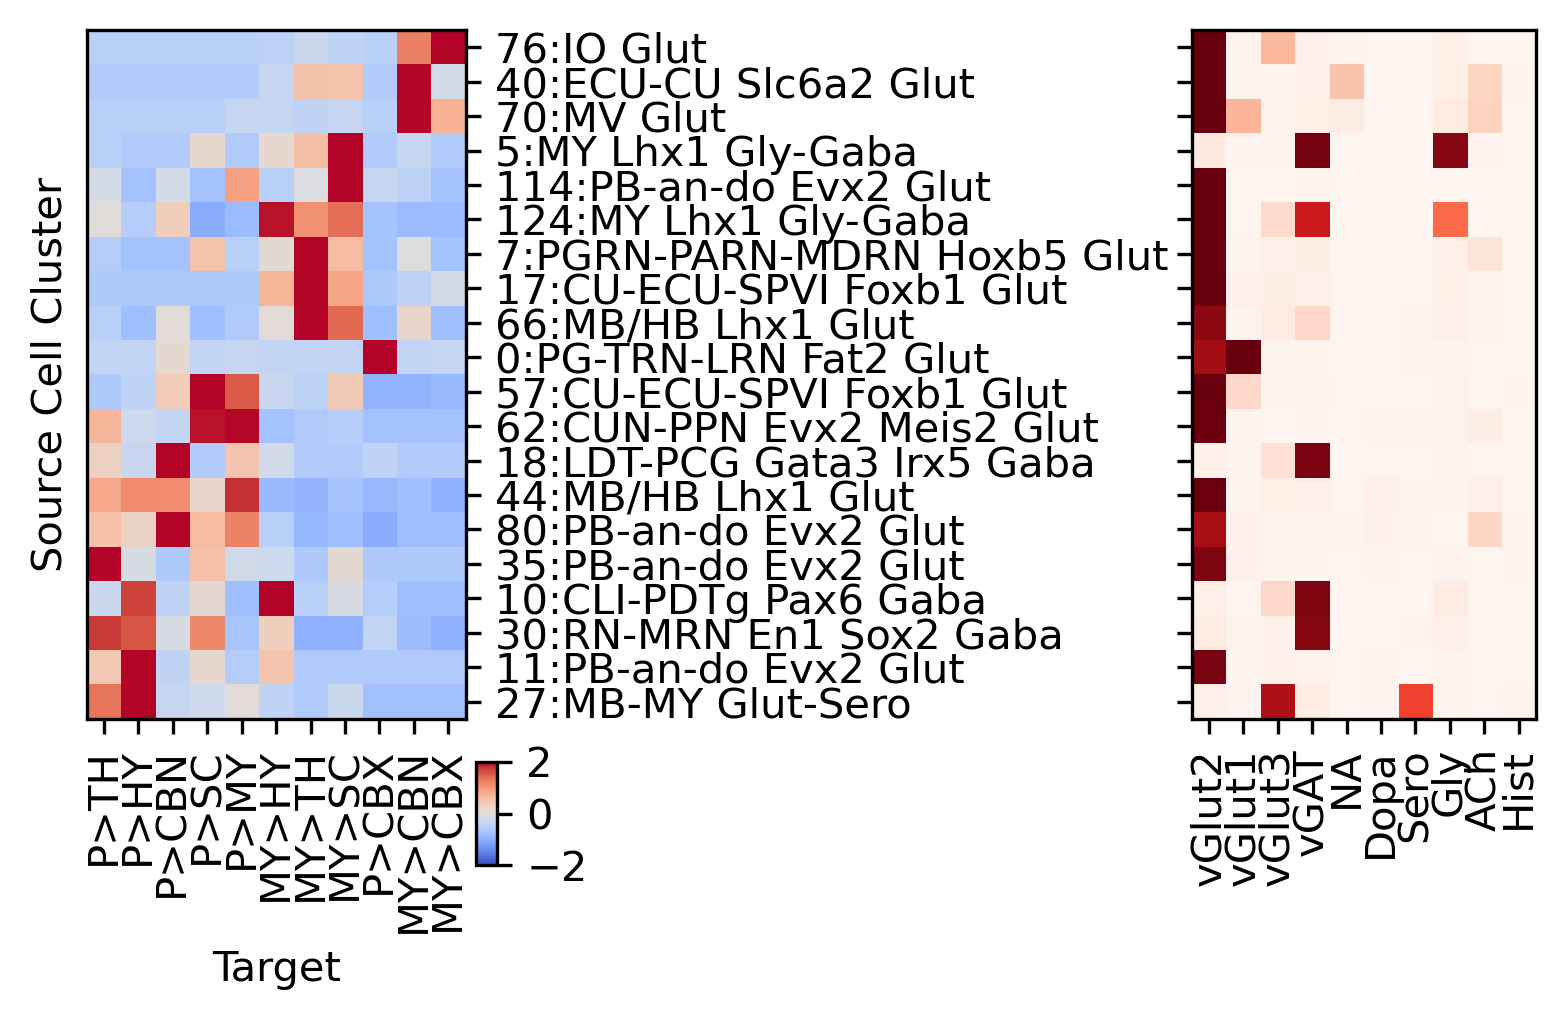

In [20]:
for reg in region_to_subregion:
    adata = anndata.read_h5ad(
        glob.glob(f"/rs2/221122-cemba-tenx-integration/{reg}/{reg}_*_rs1rs2rna.h5ad")[0]
    )
    adata.obs["leiden"] = adata.obs["leiden"].astype(int)
    if reg == "HIP":
        selc = adata.obs["leiden"].isin(hip_list)
        adata.obs.loc[selc, "leiden"] = adata.obs.loc[selc, "leiden"].map(hip_map)
    elif reg == "OLF":
        selc = adata.obs["leiden"].isin(olf_list)
        adata.obs.loc[selc, "leiden"] = adata.obs.loc[selc, "leiden"].map(olf_map)
    count = (
        adata.obs.loc[adata.obs["Study"] == "AIBS_10x", ["leiden", "L2_annot"]]
        .value_counts()
        .unstack()
        .fillna(0)
    )
    count = count / count.sum(axis=1)[:, None]
    leiden2annot = count.idxmax(axis=1)
    adata.obs["Target"] = adata.obs["Target"].astype(str)
    adata.obs.loc[~adata.obs.index.isin(meta_rs2.index), "Target"] = "?"
    target_list = [xx for xx in tarall if xx in adata.obs["Target"].values]
    cluster_list = adata.obs["leiden"].drop_duplicates().sort_values().astype(str)
    count = []
    for t in region_to_subregion[reg]:
        counttmp = (
            adata.obs.loc[
                (adata.obs["Target"] != "?")
                & adata.obs["Slice"].isin(rs2_subregion_dict[t]),
                ["Target", "leiden"],
            ]
            .value_counts()
            .unstack(fill_value=0)
        )
        tartmp = [xx for xx in tarall if xx in counttmp.index]
        counttmp = counttmp.loc[tartmp]
        counttmp.index = t + ">" + counttmp.index
        count.append(counttmp)
    count = pd.concat(count, axis=0).fillna(0)
    ratio = count / np.sum(count, axis=1)[:, None]
    clusterfilter = ((ratio > 0.05) & (count > 5)).sum(axis=0) > 0
    ratio = ratio.loc[:, clusterfilter]
    count = count.loc[:, clusterfilter]
    print(reg, ratio.shape)
    ratio.index = ratio.index.astype(str)
    ratio.columns = ratio.columns.astype(str)
    cg = sns.clustermap(
        ratio,
        z_score=1,
        metric="cosine",
        vmin=-2,
        vmax=2,
        cmap="coolwarm",
        row_cluster=True,
        figsize=(0.1, 0.1),
        xticklabels=1,
        yticklabels=1,
    )
    corder = cg.dendrogram_col.reordered_ind.copy()
    rorder = cg.dendrogram_row.reordered_ind.copy()
    exprtmp = (
        expr.loc[expr.index.isin(adata.obs.index)]
        .groupby(adata.obs["leiden"])
        .mean()
        .loc[ratio.columns.astype(int)]
    )

    fig, axes = plt.subplots(
        1, 2, figsize=(size_params[reg][0], size_params[reg][1]), dpi=300, sharey="all", gridspec_kw={"width_ratios": [size_params[reg][2], 1]}
    )

    ax = axes[0]
    plot = ax.imshow(
        zscore(ratio.iloc[rorder, corder].values, axis=0).T,
        cmap="coolwarm",
        # aspect="auto",
        vmin=-2,
        vmax=2,
    )
    cbar = plt.colorbar(plot, ax=ax, shrink=0.15, aspect=5, pad=0.02, anchor=(0, -0.25))
    ax.set_xticks(np.arange(ratio.shape[0]))
    ax.set_xticklabels(ratio.index[rorder], rotation=90)
    ax.set_yticks(np.arange(ratio.shape[1]))
    ax.yaxis.tick_right()
    # ax.yaxis.set_label_position("right")
    tmp = ratio.columns[corder] + ":" + ratio.columns[corder].astype(int).map(leiden2annot)
    ax.set_yticklabels(tmp, rotation=0)
    ax.set_ylabel("Source Cell Cluster")
    ax.set_xlabel("Target")

    ax = axes[1]
    plot = ax.imshow(exprtmp.iloc[corder, :], vmin=0, vmax=6, cmap="Reds")
    ax.set_xticks(np.arange(len(nt)))
    ax.set_xticklabels(nt, rotation=90)
    # ax.set_yticks(np.arange(ratio.shape[1]))
    # ax.set_yticklabels([])
    # cbar = plt.colorbar(plot, ax=axes[0], shrink=0.15, aspect=5, pad=0.02, anchor=(2, -0.25))
    # cbar.set_ticks(np.around([cbar.vmin, cbar.vmax], decimals=2))

    plt.tight_layout()
    plt.savefig(f"plot/{reg}_clusterratio.pdf", transparent=True)
    

In [ ]:
ratio.iloc[rorder, corder].to_hdf(
    f"/home/jzhou_salk_edu/sky_workdir/230216_projection_enrichment/ratio/{reg}_ratio.hdf",
    key="data",
)